# PF
未完成

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from da.l96 import gen_l96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.pf import ParticleFilter as PF

In [16]:
# Lorenz96の設定
J = 40
F = 8
lorenz = gen_l96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(lorenz, 0, x, 0.01)
    return x

# 単位行列
I = np.eye(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r = 1
R = r*I

# 観測値と真値
end_step = -1 # 開発用
x_true = np.load('x_true_l96.npy')[:end_step]
y = np.load('x_obs_l96.npy')[:end_step]
if not np.isclose(r, 1.0):
    y = x_true + np.random.normal(loc=0, scale=np.sqrt(r), size=x_true.shape) # R = r*I

# additive infaltion
h = 0.7

# KFの初期値
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 25*I

In [17]:
end = 100
pf = PF(M, H, R, x_0, P_0, m=1000, seed=seed, N_thr=0.5, add_inflation=h)
for y_obs in tqdm(y[:end]):
    pf.forecast(dt)
    pf.update(y_obs)

x_assim = pf.x

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Text(0.5, 1.0, 'RMSE')

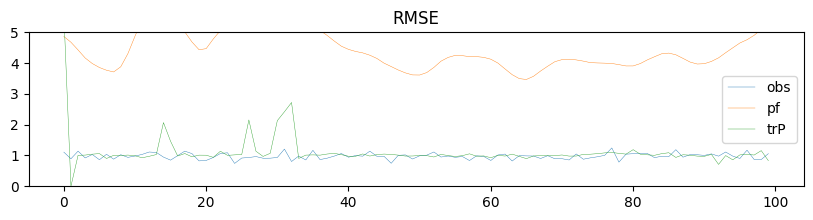

In [18]:
# plot rmse
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true[:end], y[:end], loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true[:end], x_assim[:end], loss_rms, ax=ax, label='pf', lw=0.3)
plt.plot(np.sqrt(pf.trP), lw=0.3, label='trP')
ax.legend()
ax.set_ylim([0, 5])
ax.set_title("RMSE")